In [148]:
# FIR test
import time

import numpy as np
import tensorflow as tf
import scipy

from nems.layers import FIR


rank = 2
n_outputs = 50
filter_width = 25
input_width = 1000
batch_size = 10
input_size = batch_size*input_width*rank*n_outputs

# This gives an array where a[0, :15, 0, 0] = [11,...11]   # first channel, first output, 15 time points
#                           a[0, :15, 1, 0] = [21,...21]   # second channel, first output
#                           a[0, :15, 0, 1] = [12,...12]   # first channel, second output, etc.
rank_number = (np.arange(rank)[..., np.newaxis] + 1)*10
channel_number = (np.arange(n_outputs))[np.newaxis,...] + 1
rank_and_channel = (channel_number + rank_number)[np.newaxis,...]
with_time = rank_and_channel.repeat(input_width, axis=0)[np.newaxis,...]
# TODO: test with batches as hundreds place?
input_array = with_time.repeat(batch_size, axis=0)  # all batches the same for now
# input_array = np.ones((batch_size, input_width, rank, n_outputs)).astype(float)
# input_array = np.random.rand(batch_size, input_width, rank, n_outputs)
input_from_wc = tf.constant(input_array.astype(float))

# Passthrough kernel. Channels within rank should be summed, so for example
# with rank 2, first output should be all (11+21=32), second (12+22=34), etc
fir = FIR(shape=(filter_width, rank, n_outputs))
#fir.sample_from_priors()  # test random
#coefs_array = fir.coefficients
coefs_array = np.zeros((filter_width, rank, n_outputs))
coefs_array[0, :, :] = 1
coefs_array[1, :, :] = -0.5
fir.set_parameter_values(coefficients=coefs_array)
coefficients = fir._reshape_coefficients().astype(float)
coefs = tf.constant(coefficients)


# TODO: should be able to do scipy version the same way, with np.apply or similar.
#       Using GPU doesn't speed this one up for some reason, but can add a hook
#       in as_tf_layer to use the other call if no gpu.
# TODO: this is still quite slow. A lot of people reporting issues have said they
#       get better performance by just converting to numpy and back within call()
# TODO: how hard to switch to N-D convolution for TensorFlow? (I saw they have
#       an equivalent fn but need to see what extra work is involved if any)
@tf.function
def my_func1():
    new_coefs = tf.expand_dims(tf.transpose(coefs, [2, 0, 1]), -1)  # outputs, width, rank, 1
    reversed_coefs = tf.reverse(new_coefs, axis=[1])  # flip time axis
    padded_input = tf.pad(input_from_wc, [[0,0], [filter_width-1,0], [0,0], [0,0]])
    x = tf.transpose(padded_input, [3, 0, 1, 2])  # outputs, batch, width, rank
    y = tf.map_fn(
        fn = lambda t: tf.nn.conv1d(t[0], t[1], stride=1, padding='VALID'),
        elems = (x, reversed_coefs),
        fn_output_signature=tf.float64
        )
    z = tf.transpose(tf.squeeze(y, axis=3), [1, 2, 0])  # batch, width, outputs
    return z

# old CPU version is much slower
# Can't use tf.function optimization b/c of list append
def my_func2():
    transposed = tf.transpose(input_from_wc, [0, 1, 3, 2])  # groups by output before rank w/o transpose
    reshaped = tf.reshape(transposed, [batch_size, input_width, rank*n_outputs])
    padded_input = tf.pad(reshaped, [[0, 0], [filter_width-1, 0], [0, 0]])
    reversed_coefs = reversed_coefs = tf.reverse(coefs, axis=[0])
    L = []
    for i in range(reshaped.shape[2]):
        W = reversed_coefs.shape[1]
        A = padded_input[:, :, (i*W):((i+1)*W)]
        B = reversed_coefs[:, :, i:(i+1)]
        L.append(tf.nn.conv1d(A, B, stride=1, padding='VALID'))
    Y = tf.concat(L, axis=2)
    return Y

# Grouped convolutions are still much faster (on GPU), but can't run on CPU
# Also, this seems to be about the same speed for larger output and batch size.
# I.e. for the sizes we're working with, most of the %timeit clock is probably
# just the overhead for porting to GPU (so the speed difference should be even
# bigger during optimization)
@tf.function
def my_func3():
    transposed = tf.transpose(input_from_wc, [0, 1, 3, 2])  # groups by output before rank w/o transpose
    reshaped = tf.reshape(transposed, [batch_size, input_width, rank*n_outputs])
    reversed_coefs = tf.reverse(coefs, axis=[0])
    padded_input = tf.pad(reshaped, [[0, 0], [filter_width-1, 0], [0, 0]])
    y = tf.nn.conv1d(padded_input, reversed_coefs, stride=1, padding='VALID')
    return y


# Scipy versions ####

input = input_array[0,...]  # don't include batches
padding = fir._get_filter_padding()
#input_with_padding = np.concatenate([input, padding])  # switched?? why? TODO, compare to old NEMS again
input_with_padding = np.concatenate([padding, input])

# nditer
def fir_1():
    outputs = []
    iterator = np.nditer(np.moveaxis(input_with_padding, 2, 0), flags=['external_loop'], order='C')
    for i, x in enumerate(iterator):
        # Have to reshape b/c iterator always returns 1d slices
        y = scipy.signal.convolve(
            x.reshape(input_width + filter_width-1, rank),
            coefficients[...,i], mode='valid'
            )
        outputs.append(y[..., np.newaxis])
    output = np.concatenate(outputs, axis=2)
    # TODO: This just squeezes out rank, but also need to squeeze out
    #       any extra dims for higher-D data.
    return np.squeeze(output, axis=1)

# double indexing
# This is faster, oddly enough, and not just for me: this seems to be the
# consensus from several stackoverflow posts. Faster than nditer, faster than
# apply_over_axes, etc, and I'm not sure how else to implement this. The
# grouped convolutions happening in tensorflow are implemented at the C level
# in the cuDNN library so I wouldn't even know where to begin to try to
# reimplement that here (and that's definitely not a priority).
def fir_2():
    outputs = []
    for i in range(coefficients.shape[-1]):
        y = scipy.signal.convolve(
            input_with_padding[...,i], coefficients[...,i], mode='valid'
            )
        outputs.append(y[..., np.newaxis])
    output = np.concatenate(outputs, axis=2)
    return np.squeeze(output, axis=1)



from itertools import chain, repeat

import numpy as np
import scipy.signal
from scipy import interpolate
from scipy.ndimage.filters import convolve1d

# Compare against old FIR

def get_zi(b, x):
    # This is the approach NARF uses. If the initial value of x[0] is 1,
    # this is identical to the NEMS approach. We need to provide zi to
    # lfilter to force it to return the final coefficients of the dummy
    # filter operation.
    n_taps = len(b)
    #null_data = np.full(n_taps*2, x[0])
    null_data = np.full(n_taps*2, 0)
    zi = np.ones(n_taps-1)
    return scipy.signal.lfilter(b, [1], null_data, zi=zi)[1]


def _insert_zeros(coefficients, rate=1):
    if rate<=1:
        return coefficients

    d1 = int(np.ceil((rate-1)/2))
    d0 = int(rate-1-d1)
    s = coefficients.shape
    new_c = np.concatenate((np.zeros((s[0],s[1],d0)),
                            np.expand_dims(coefficients, axis=2),
                            np.zeros((s[0],s[1],d1))), axis=2)
    new_c = np.reshape(new_c, (s[0],s[1]*rate))
    return new_c


def per_channel(x, coefficients, bank_count=1, non_causal=0, rate=1,
                cross_channels=False):
    '''Private function used by fir_filter().
    Parameters
    ----------
    x : array (n_channels, n_times) or (n_channels * bank_count, n_times)
        Input data. Can be sized two different ways:
        option 1: number of input channels is same as total channels in the
          filterbank, allowing a different stimulus into each filter
        option 2: number of input channels is same as number of coefficients
          in each fir filter, so that the same stimulus goes into each
          filter
    coefficients : array (n_channels * bank_count, n_taps)
        Filter coefficients. For ``x`` option 2, input channels are nested in
        output channel, i.e., filter ``filter_i`` of bank ``bank_i`` is at
        ``coefficients[filter_i * n_banks + bank_i]``.
    bank_count : int
        Number of filters in each bank.
    Returns
    -------
    signal : array (bank_count, n_times)
        Filtered signal.
    '''
    # Make sure the number of input channels (x) match the number FIR filters
    # provided (we have a separate filter for each channel). The `zip` function
    # doesn't require the iterables to be the same length.
    n_in = len(x)
    if rate > 1:
        coefficients = _insert_zeros(coefficients, rate)
        print(coefficients)
    n_filters = len(coefficients)
    if bank_count>0:
        n_banks = int(n_filters / bank_count)
    else:
        n_banks = n_filters
    if cross_channels:
        # option 0: user has specified that each filter should be applied to
        # each input channel (requires bank_count==1)
        # TODO : integrate with core loop below instead of pasted hack
        out = np.zeros((n_in*n_filters, x.shape[1]))
        i_out=0
        for i_in in range(n_in):
            x_ = x[i_in]
            for i_bank in range(n_filters):
                c = coefficients[i_bank]
                zi = get_zi(c, x_)
                r, zf = scipy.signal.lfilter(c, [1], x_, zi=zi)
                out[i_out] = r
                i_out+=1
        return out
    elif n_filters == n_in:
        # option 1: number of input channels is same as total channels in the
        # filterbank, allowing a different stimulus into each filter
        all_x = iter(x)
    elif n_filters == n_in * bank_count:
        # option 2: number of input channels is same as number of coefficients
        # in each fir filter, so that the same stimulus goes into each
        # filter
        one_x = tuple(x)
        all_x = chain.from_iterable([one_x for _ in range(bank_count)])
    else:
        if bank_count == 1:
            desc = '%i FIR filters' % n_filters
        else:
            desc = '%i FIR filter banks' % n_banks
        raise ValueError(
            'Dimension mismatch. %s channels provided for %s.' % (n_in, desc))

    c_iter = iter(coefficients)
    out = np.zeros((bank_count, x.shape[1]))
    for i_out in range(bank_count):
        for i_bank in range(n_banks):
            x_ = next(all_x)
            c = next(c_iter)
            if non_causal:
                # reverse model (using future values of input to predict)
                x_ = np.roll(x_, -non_causal)

            # It is slightly more "correct" to use lfilter than convolve at
            # edges, but but also about 25% slower (Measured on Intel Python
            # Dist, using i5-4300M)
            zi = get_zi(c, x_)
            r, zf = scipy.signal.lfilter(c, [1], x_, zi=zi)
            out[i_out] += r
    return out

def old_fir():
    # merge rank and outputs
    old_input = input.swapaxes(1, 2).reshape(input_width, rank*n_outputs).swapaxes(0,1)
    old_c = coefs_array.swapaxes(0,1)
    if old_c.ndim == 3:
        d1, d2, d3 = old_c.shape
        old_c = np.concatenate(np.split(old_c, d3, axis=2), axis=0).squeeze()
        banks = d3
    return per_channel(old_input, old_c, bank_count=banks).T

C:\Users\jacob\AppData\Local\Temp\ipykernel_10656\3239220293.py:143: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve1d


In [149]:
# All TF equiv, all scipy equiv
print(np.all(my_func1() == my_func2()))
print(np.all(my_func1() == my_func3()))
print(np.all(fir_1() == fir_2()))
# TF equiv to scipy (ignoring batches, and some rounding error)
# TODO: had to switch padding from prepend to append for scipy to get this
#       to match, why? what changed from before?
# Answer: Had to flip time dimension of coefs in TF function. Something weird with TF conv1d?
print(np.all(my_func1().numpy()[0,...].round(10) == fir_2().round(10)))
print(np.all(my_func3().numpy()[0,...].round(10) == old_fir().round(10)))
print(np.all(fir_2().round(8) == old_fir().round(8)))

True
True
True
True
True
True


In [136]:
old_fir()[:100, 0]

array([32., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16.])

In [137]:
my_func3().numpy()[0,:100,0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0., -16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,
        16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,
        16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,
        16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,
        16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,
        16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,
        16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,
        16.])

In [133]:
old_fir()[:100, 0]

array([32., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16.])

In [134]:
my_func3()[0, :100, 0]

<tf.Tensor: shape=(100,), dtype=float64, numpy=
array([16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16.])>

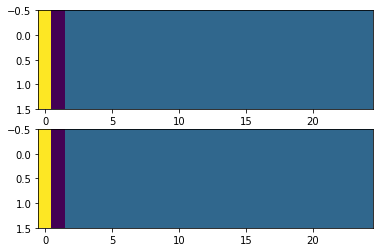

In [131]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1)
# ax1.imshow(my_func3().numpy()[0,:,:3].T, aspect='auto', interpolation='none')
# ax2.imshow(old_fir()[:,:3].T, aspect='auto', interpolation='none')
ax1.imshow(coefs.numpy()[:,:,0].T, aspect='auto')
ax2.imshow(coefficients[:,:,0].T, aspect='auto')

In [ ]:
with tf.device("/device:CPU:0"):
    my_func1() # compile
    my_func2()
    %timeit -n 10 my_func1()  # new CPU
    %timeit -n 10 my_func2()  # old CPU

90.3 ms ± 4.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
129 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
with tf.device("/GPU:0"):
    my_func1()
    my_func2()
    %timeit -n 10 my_func1()         # new GPU
    %timeit -n 10 my_func3()         # old GPU

109 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.88 ms ± 381 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit fir_1()
%timeit fir_2()

21.6 ms ± 3.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
19.9 ms ± 3.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# TODO: Needs lower Numpy version
#       Also possibly incompatible with TF? Noticed it installs
#       MKL, which I was having issues with. Should test with
#       a separate environment

# with numba
from numba import jit

@jit(nopython=True)
def num_fir1():
    fir_1()

@jit(nopython=True)
def num_fir2():
    fir_2()

# compile
num_fir1()
num_fir2()
%timeit -n 100 num_fir1()
%timeit -n 100 num_fir2()

In [ ]:
# WC test
# Comment out to use same as FIR
# rank = 4
# n_outputs = 12
# input_width = 1000
# batch_size = 1
# input_size = batch_size*input_width*rank*n_outputs
# WC only
input_channels = 18

# Input is all ones for first channel, all twos for second channel, etc.
# (same for all batches)
# channel_number = (np.arange(input_channels))[np.newaxis,...] + 1
# with_time = channel_number.repeat(input_width, axis=0)[np.newaxis,...]
# input_array = with_time.repeat(batch_size, axis=0)
# inputs = tf.constant(input_array.astype(float))
inputs = tf.constant(np.random.rand(batch_size, input_width, input_channels))

# 1/input_channels for all channels, so output should be sum of channel numbers
#coefs = np.ones((input_channels, rank, n_outputs))
#output_should_be = sum(range(1, input_channels+1))
coefs = np.random.rand(input_channels, rank, n_outputs)

@tf.function
def my_func4():
    # new version (tensordot)
    out = tf.tensordot(inputs, coefs, axes=[[2], [0]])
    return out
    # return tf.reshape(out, [batch_size, input_width, -1])

@tf.function
def my_func5():
    # old version (convolution)
    transposed = tf.transpose(coefs, [0, 2, 1])
    reshaped = tf.reshape(coefs, [input_channels, rank*n_outputs])
    return tf.nn.conv1d(
        inputs, tf.expand_dims(reshaped, 0), stride=1,
        padding='SAME'
        )


def wc_1():
    return np.moveaxis(inputs.numpy()[0,...] @ np.moveaxis(coefs, -1, 0), 0, -1)

def wc_2():
    return np.tensordot(inputs.numpy()[0,...], coefs, axes=(1, 0))
    

In [ ]:
my_func5().shape

TensorShape([10, 1000, 50])

In [ ]:
# TF functions equivalent
print(np.all(my_func4() == tf.reshape(my_func5(), [batch_size, input_width, rank, n_outputs])))

# scipy equivalent to each other within decent precision
print(np.all(wc_1().round(10) == wc_2().round(10)))

# TF equivalent to scipy
print(np.all(my_func4().numpy()[0,...].round(10) == wc_1().round(10)))

True
True
True


In [ ]:
%timeit -n 10 with tf.device("/device:CPU:0"): my_func4()  # new CPU
%timeit -n 10 with tf.device("/device:CPU:0"): my_func5()  # old CPU

7.07 ms ± 964 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.99 ms ± 738 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 with tf.device("/GPU:0"): my_func4()         # new GPU
%timeit -n 10 with tf.device("/GPU:0"): my_func5()         # old GPU

1.4 ms ± 506 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.55 ms ± 508 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# Scipy version. Why is this so much faster? Overhead with setting up
# TF objects maybe?
# Ah... Still much faster than TF-CPU, but GPU scales better. So yes, probably
# a lot of the TF time is overhead that wouldn't be important during fitting.
%timeit wc_1()
%timeit wc_2()

2.03 ms ± 502 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.67 ms ± 340 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
# Does moving axes on the coefs add much?
# Answer: yeah some, it's ~25% slower with those ops. But probably not enough
# to make a huge difference.
coefs2 = np.moveaxis(coefs, -1, 0)
%timeit np.moveaxis(inputs.numpy()[0,...] @ coefs2, 0, -1)